In [1]:
print('Meu nome é: Gabriel Moraes Barros ')
print('Meu RA é: 192801')

Meu nome é: Gabriel Moraes Barros 
Meu RA é: 192801


In [2]:
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
import torch
import torch.optim as optim
from torch.autograd import Variable
import pandas as pd

In [3]:
iris = load_iris()
print(type(iris))
print('iris.data:',iris.data.shape,iris.data.dtype,iris.data.min(),iris.data.max())
print('iris.target:',iris.target.shape,iris.target.dtype,iris.target.min(),iris.target.max())
#print(iris.DESCR)
print('iris.features_name:',iris.feature_names)
print('iris.target_names:',iris.target_names)

iris_pd = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_pd['target'] = iris.target


<class 'sklearn.datasets.base.Bunch'>
iris.data: (150, 4) float64 0.1 7.9
iris.target: (150,) int64 0 2
iris.features_name: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
iris.target_names: ['setosa' 'versicolor' 'virginica']


In [4]:
data = iris.data[iris.target==1,::2]  # comprimento das sépalas e pétalas, indices 0 e 2

x = data[:,0:1]
y = data[:,1:2]

print('x.shape:',x.shape, x.dtype)
print('y.shape:',y.shape, y.dtype)


x.shape: (50, 1) float64
y.shape: (50, 1) float64


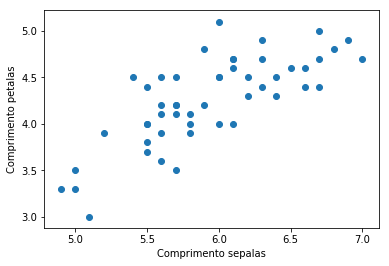

In [5]:
plt.scatter(x, y)
plt.xlabel('Comprimento sepalas')
plt.ylabel('Comprimento petalas')
plt.show()

In [6]:
x -= x.min()
x /= x.max()    # normalização
y -= y.min()
y /= y.max()

#y = 2*x        # útil para verificar se o programa está funcionando (como exercício)

In [7]:
y2=y

## Visualização dos dados normalizados


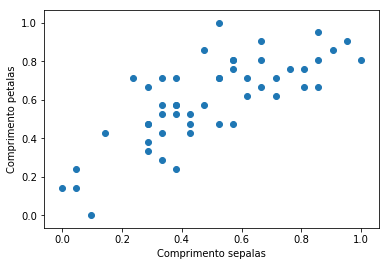

In [8]:
plt.scatter(x, y)
plt.xlabel('Comprimento sepalas')
plt.ylabel('Comprimento petalas')
plt.show()

### Código compute_cost

In [9]:
def compute_cost(X_b, y, wT):
    '''
    Compute cost for linear regression
    (X,y): amostras rotuladas X(n_samples,2) e y(n_samples,)
    wT: vetor coluna de parâmetros (já transposto)
       aceita tanto shape (2,1) Para um caso como (2,n_history) para n_history casos
    '''
    e = X_b.dot(wT) - y
    J = (e * e).mean(axis=0)
    return J

### Gradiente Descendente por Lote (*batch*)

In [10]:
def batch_gradient_descent(X, y, W_init, lr, n_epochs):
    #var.data.numpy() trasforma um tensor 'var' em um numpy
    #m = y.size
    M = y.size
    W_history = np.zeros((2, n_epochs+1))
    wT = W_init.T
    
    
    W_history[:,0] = wT[:,0]
    
    
    def tensors(X,y,W,dtype):
        
        X = Variable(torch.from_numpy(X).type(dtype), requires_grad=False)
        y = Variable(torch.from_numpy(y).type(dtype), requires_grad=False)
        W = Variable(torch.from_numpy(W).type(dtype), requires_grad=True)
        return X,y,W

    X,y,W = tensors(X,y,wT,torch.FloatTensor)
    
    for i in range(n_epochs):
        
        loss = (X.mm(W) - y).pow(2).sum()
        loss.backward()
        
        W.data -= lr / M * W.grad.data
        W_history[:, i+1] = W.data.numpy()[:,0]

        W.grad.data.zero_()
        
    return W_history.T

### Laço de minimização via gradiente descendente - Código

In [11]:
# Parâmetros do gradiente descendente: número de iterações e taxa de aprendizagem
iterations = 400
lr = 0.01

n_samples = y.shape[0]
print(y.shape)

#Montagem da matriz X agora com os elementos 1 na primeira coluna
X_bias = np.hstack([np.ones(shape=(n_samples,1)), x])

w_init = np.zeros(shape=(1,2))


w_history = batch_gradient_descent(X_bias, y, w_init, lr, iterations)
#print(w_history)


w_gd = w_history[::-1][0:1] # pega o último valor do gradiente descendente

print('w_gd:\n', w_gd)

print('final cost (gradiente descendente):', compute_cost(X_bias, y, w_gd.T))

J_history = compute_cost(X_bias, y, w_history.T)

print(J_history[:10])

(50, 1)
w_gd:
 [[ 0.41560832  0.38846883]]
final cost (gradiente descendente): [ 0.0264799]
[ 0.40907029  0.39037456  0.37260487  0.3557153   0.33966222  0.32440414
  0.30990164  0.29611727  0.28301541  0.27056222]


### Plot da curva de minimização de J com o número de iterações

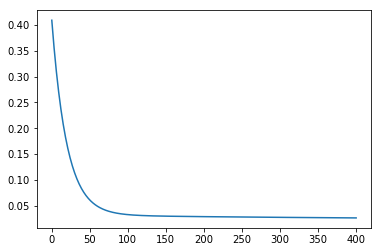

In [12]:
plt.plot(J_history) # mostrando log para amplificar valores baixos
#plt.ylim(0,1)
plt.show()

## Comparando com a solução analítica

A solução analítica deste problema é dada por:

$$  \mathbf{w} =(\mathbf{X}^T \mathbf{X})^{−1}\mathbf{X}^T \mathbf{y} $$

In [13]:
w_opt = (np.linalg.inv((X_bias.T).dot(X_bias)).dot(X_bias.T)).dot(y)
print(w_opt)
print('final cost (analítica):', compute_cost(X_bias, y, w_opt))

[[ 0.26134159]
 [ 0.68646976]]
final cost (analítica): [ 0.02116942]


## Plotagem da reta de predição (solução analítica e solução via gradiente descendente)

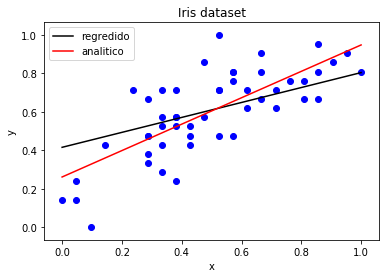

In [14]:
plt.scatter(x, y, marker='o', c='b')
plt.title('Iris dataset')
plt.xlabel('x')
plt.ylabel('y')

# Plotagem da reta utilizando os parâmetros ótimos encontrados no gradiente descendente

X_all = np.linspace(x.min(),x.max(),100).reshape(100,1)
X_all_bias = np.hstack([np.ones((100,1)),X_all])
result = X_all_bias.dot(w_gd.T)  # Predição via minimização gradiente descendente
plt.plot(X_all, result, c='k',label='regredido')
result_opt = X_all_bias.dot(w_opt)  # Predição do valor analítico
plt.plot(X_all, result_opt,c='r', label='analitico')
plt.legend()
plt.show()

from Jview import Jview

Jview(X_bias, y, w_history, w_opt)



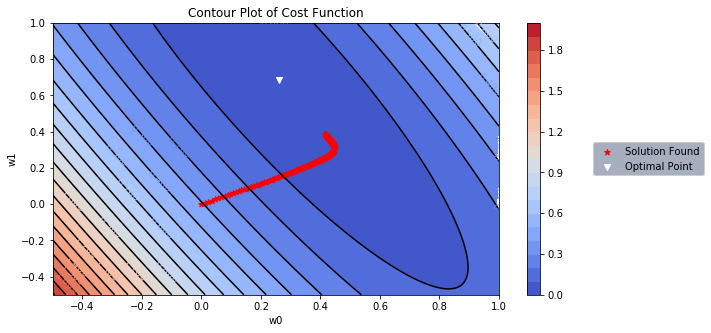

In [15]:
import matplotlib.cm as cm

def contour_plot(X_bias, y, w_history, w_opt):

    size = 256
    w0 = np.linspace(-0.5,1,size)
    w1 = np.linspace(-0.5,1,size)
    J_history_2 = np.zeros((len(w0),len(w1)))
    ws1, ws2 = np.meshgrid(w0,w1)
    w_grid = np.c_[ws1.ravel(), ws2.ravel()]

    J_history_2 = compute_cost(X_bias,y,w_grid.T)
    J_history_2 = J_history_2.reshape(size,size)
    
    fig = plt.figure(figsize=(10.0,5.0))
    CS = plt.contourf(w0, w1, J_history_2,20, cmap=cm.coolwarm ,label='Cost Function')
    plt.scatter(w_history[:,0],w_history[:,1], marker='*', color='r', label='Solution Found')
    plt.scatter(w_opt[0],w_opt[1], marker='v', color='w', label='Optimal Point')
    CB = plt.contour(w0, w1, J_history_2,20, colors='black', linewidth=.5)
    
    plt.clabel(CS, inline=1, fontsize=10)
    plt.colorbar(CS)
    plt.title("Contour Plot of Cost Function")
    plt.xlabel("w0")
    plt.ylabel("w1")
    #plt.figure(figsize=(10,6))
    
    #plt.legend(loc='best')
    legend = plt.legend(loc='center left', bbox_to_anchor=(1.2, 0.5))
    legend.get_frame().set_facecolor('#929aae')
    fig.savefig('fig_2D.png', bbox_extra_artists=(legend,), bbox_inches='tight')
    plt.show(fig)
contour_plot(X_bias, y, w_history, w_opt)